Processing complete!
Rows: 8807
Normalization complete!
Rows after normalization: 8807
                         Date  ev_transpiration      rain  pan_ev  max_temp  \
Station Name                                                                  
BOMBALA            2024-10-01          0.216216  0.001282     0.0  0.397802   
CAMDEN AIRPORT     2024-10-01          0.229730  0.000000     0.0  0.558242   
BEGA               2024-10-01          0.216216  0.000000     0.0  0.496703   
CONDOBOLIN AIRPORT 2024-10-01          0.250000  0.001282     0.0  0.534066   
COOMA AIRPORT      2024-10-01          0.216216  0.000000     0.0  0.452747   

                    min_temp  max_humid  min_humid      wind     solar  \
Station Name                                                             
BOMBALA             0.211886   1.000000   0.303030  0.144020  0.633101   
CAMDEN AIRPORT      0.403101   0.988095   0.333333  0.055980  0.689930   
BEGA                0.341085   1.000000   0.464646  0.099237  0

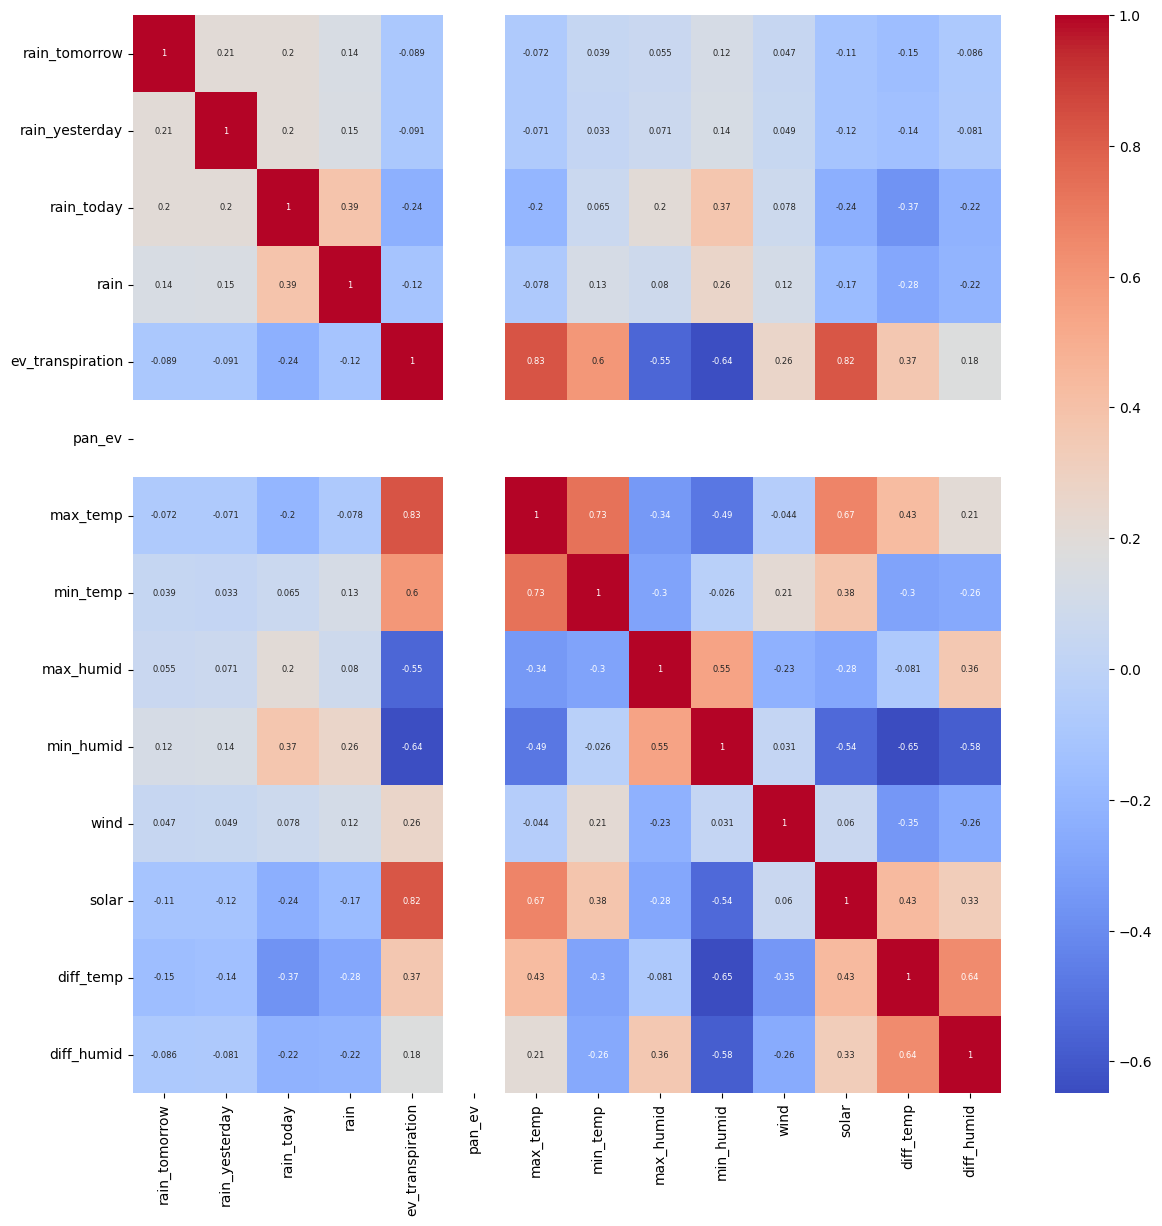

Total rows after dropna: 8807
n_iter (per class): [69]
Val accuracy: 62.88%
Logistic Regression Classification Report
              precision    recall  f1-score   support

    Not Rain       0.63      1.00      0.77      1110
        Rain       0.33      0.00      0.01       652

    accuracy                           0.63      1762
   macro avg       0.48      0.50      0.39      1762
weighted avg       0.52      0.63      0.49      1762



In [3]:
# %% [code]
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Read the file
filename = '/kaggle/input/weather-dataset4/Csv file weather(3).csv'
observe = pd.read_csv(filename, sep=',', index_col=0)

# Adjust column types
int_col = ['ev_transpiration','rain','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar']
for col in int_col:
    observe[col] = pd.to_numeric(observe[col], errors='coerce')
    observe[col] = observe[col].astype(float)

observe['Date'] = pd.to_datetime(observe['Date'], format='%d/%m/%Y')

# Sort values
observe = observe.sort_values(['Date'])

## fill nan value with mean
for col in int_col:
    observe[col] = observe[col].fillna(observe[col].mean())

print("Processing complete!")
print(f"Rows: {len(observe)}")

# %% [code]
# Add rain today, rain yesterday column
observe['rain_today'] = np.where(observe['rain'] > 0, 1, 0)
observe['rain_yesterday'] = (observe['rain_today'].shift(1) == 1).astype(int).fillna(0)
observe['rain_tomorrow'] = (observe['rain_today'].shift(-1) == 1).astype(int).fillna(0)

# Add difference temp, humid
observe['diff_temp'] = observe['max_temp'] - observe['min_temp']
observe['diff_humid'] = observe['max_humid'] - observe['min_humid']

# Get month number from datetime
observe['month_number'] = observe['Date'].dt.month

# Normalize columns - SIMPLE FIX: Direct normalization
norm_col = ['ev_transpiration','rain','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar', 'diff_temp', 'diff_humid']
scaler = MinMaxScaler()
observe[norm_col] = scaler.fit_transform(observe[norm_col])

print("Normalization complete!")
print(f"Rows after normalization: {len(observe)}")
print(observe.head())

# %% [code]
# Correlation heatmap
plt.figure(figsize=(14, 14))
corr_col = ['rain_tomorrow','rain_yesterday', 'rain_today', 'rain', 'ev_transpiration','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar', 'diff_temp', 'diff_humid']
sns.heatmap(observe[corr_col].corr(), annot=True, cmap="coolwarm", annot_kws={"size": 6})
plt.show()

# %% [code]
## prepare data set, then split train, test set

# Remove rows with any NaN values
observe = observe.dropna()

print(f"Total rows after dropna: {len(observe)}")

# Check if we have enough data
if len(observe) == 0:
    print("ERROR: No data left after removing NaN values!")
    print("Check your data processing steps.")
else:
# --- keep everything above as-is ---

    x_col = ['ev_transpiration','max_temp','min_temp','max_humid','min_humid','wind','solar','month_number']
    X = observe[x_col]
    y = observe['rain_tomorrow']
    
    # Prefer a time-aware split for weather (older -> train, newer -> val)
    cut = int(len(observe) * 0.8)
    X_train, X_val = X.iloc[:cut], X.iloc[cut:]
    y_train, y_val = y.iloc[:cut], y.iloc[cut:]
    
    from sklearn.linear_model import LogisticRegression
    
    log_reg_model = LogisticRegression(
        solver="lbfgs",     # good default for dense data
        max_iter=20000,      # more iterations = easier convergence
        tol=1e-3,           # slightly looser stopping criterion
        C=0.8,              # a bit more regularization helps conditioning
        class_weight=None   # or "balanced" if rain is rare
    )
    log_reg_model.fit(X_train, y_train)
    
    print("n_iter (per class):", getattr(log_reg_model, "n_iter_", None))
    
    log_reg_model_score = log_reg_model.score(X_val, y_val)
    print(f"Val accuracy: {log_reg_model_score*100:.2f}%")
    
    y_pred = log_reg_model.predict(X_val)
    
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_val, y_pred)
    print('Logistic Regression Classification Report')
    print('=========================================')
    print(classification_report(y_val, y_pred, target_names=['Not Rain','Rain']))


In [4]:
import joblib

# Save model and scaler
joblib.dump(log_reg_model, "log_reg_weather_model2.pkl")
joblib.dump(scaler, "scaler2.pkl")

['scaler2.pkl']

Training

In [5]:
import pandas as pd
import joblib
import numpy as np


# Load trained model and scaler
log_reg_model = joblib.load("/kaggle/working/log_reg_weather_model2.pkl")
scaler = joblib.load("/kaggle/working/scaler2.pkl")

# The features your model used at train time
x_col = ['ev_transpiration','max_temp','min_temp',
         'max_humid','min_humid','wind','solar','month_number']

# Columns the scaler expects (exactly as during training)
expected_scaled_cols = list(scaler.feature_names_in_)
print("Scaler expects:", expected_scaled_cols)

def predict_tomorrow(weather_dict):
    """
    weather_dict must contain raw values for:
        ev_transpiration, rain, pan_ev, max_temp, min_temp,
        max_humid, min_humid, wind, solar, month_number
    """
    # --- compute engineered features ---
    raw = dict(weather_dict)
    raw['diff_temp']  = raw['max_temp']  - raw['min_temp']
    raw['diff_humid'] = raw['max_humid'] - raw['min_humid']

    # --- build row for scaler ---
    scaled_input_row = pd.DataFrame([[raw[c] for c in expected_scaled_cols]],
                                    columns=expected_scaled_cols)

    # --- scale ---
    scaled_values = scaler.transform(scaled_input_row)
    scaled_df     = pd.DataFrame(scaled_values, columns=expected_scaled_cols)

    # --- final model input (scaled 7 + raw month_number) ---
    X_row = pd.DataFrame([{
        'ev_transpiration': float(scaled_df.at[0, 'ev_transpiration']),
        'max_temp':        float(scaled_df.at[0, 'max_temp']),
        'min_temp':        float(scaled_df.at[0, 'min_temp']),
        'max_humid':       float(scaled_df.at[0, 'max_humid']),
        'min_humid':       float(scaled_df.at[0, 'min_humid']),
        'wind':            float(scaled_df.at[0, 'wind']),
        'solar':           float(scaled_df.at[0, 'solar']),
        'month_number':    int(raw['month_number'])
    }])[x_col]

    # --- predict ---
    pred_label = log_reg_model.predict(X_row)[0]
    proba      = log_reg_model.predict_proba(X_row)[0]

    return {
        "prediction": "Rain" if pred_label == 1 else "Not Rain",
        "proba_not_rain": float(proba[0]),
        "proba_rain": float(proba[1])
    }

# ===== example usage =====
today = {
    'ev_transpiration': 3.2,
    'rain': 0.0,        # today's rainfall (mm)
    'pan_ev': 4.1,
    'max_temp': 30,
    'min_temp': 22,
    'max_humid': 85,
    'min_humid': 45,
    'wind': 12,
    'solar': 20,
    'month_number': 10  # October
}

result = predict_tomorrow(today)
print(result)


Scaler expects: ['ev_transpiration', 'rain', 'pan_ev', 'max_temp', 'min_temp', 'max_humid', 'min_humid', 'wind', 'solar', 'diff_temp', 'diff_humid']
{'prediction': 'Not Rain', 'proba_not_rain': 0.5035487260920416, 'proba_rain': 0.4964512739079584}
